In [1]:
import os
import cv2
import numpy as np
import math
from PIL import Image

In [2]:
def to_images(file_path):
  import fitz
  doc = fitz.open(file_path)
  images = []
  for index in range(0, doc.page_count):
    page = doc.load_page(index)
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    images.append(img)
  return images

In [3]:
class Page:
  def __init__(self, master, image):
    self.master = master
    self.image = image
    gray = cv2.cvtColor(np.array(image.convert('RGB'))[:, :, ::-1].copy(), cv2.COLOR_BGR2GRAY)
    self.height, self.width = gray.shape

    self.thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    output = cv2.connectedComponentsWithStats(self.thresh, 8, cv2.CV_32S)
    (_, _, self.ccs, self.centroids) = output

  def compute_horizontal_projection(self):
    hs = [0] * (self.master.shape[1] + 1)

    def collect_horizontal_runlengths(x, y, w, h):
      for y_ in range(y, y + h):
        hs[y_] += np.count_nonzero(self.thresh[y_][x : x + w] == 255)

    for (x, y, w, h, _) in self.ccs:
      if w / h < 3:
        continue
      collect_horizontal_runlengths(x, y, w, h)
    return np.array(hs)

  def plot_horizontal_projection(self):
    import matplotlib.pyplot as plt
    f = plt.figure()
    f.set_figwidth(50)
    f.set_figheight(10)
    hs = self.compute_horizontal_projection()
    plt.plot(hs, color='black')

  def plot_baselines(self):
    hs = self.compute_horizontal_projection()
    hs[hs < 0.8 * self.master.oligon_width] = 0
    import matplotlib.pyplot as plt
    f = plt.figure()
    f.set_figwidth(50)
    f.set_figheight(10)
    plt.plot(hs, color='black')

class Sheet:
  def __init__(self, file_path):
    images = to_images(file_path)
    self.pages = []
    for image in images:
      self.pages.append(Page(self, image))

    # Compute the shape.
    self.shape = (max(p.width for p in self.pages), max(p.height for p in self.pages))

    # Compute oligon parameters.
    self.oligon_width = self.compute_oligon_width()
    self.oligon_height = self.compute_oligon_height()

  def compute_oligon_width(self):
    ws = [0] * (self.shape[0] + 1)
    for p in self.pages:
      for (_, _, w, h, _) in p.ccs:
        if w / h < 3:
          continue
        ws[w] += 1
    total = sum(ws)
    curr = 0
    print(ws)
    for i in range(1, self.shape[0] + 1):
      curr += ws[i]
      if curr >= total / 2:
        return i + 1
    return None

  def compute_oligon_height(self):
    hs = [0] * (self.shape[1] + 1)
    
    def collect_vertical_runlengths(p, x, y, w, h):
      for x_ in range(x, x + w):
        sum = 0
        for y_ in range(y, y + h):
          bit = int(p.thresh[y_][x_] == 255)
          if bit == 1:
            sum += 1
          else:
            hs[sum] += 1
            sum = 0
        hs[sum] += 1

    for p in self.pages:
      for (x, y, w, h, _) in p.ccs:
        if w / h < 3:
          continue
        collect_vertical_runlengths(p, x, y, w, h)
        
    max_freq = 0
    oligon_height = None
    for i in range(1, self.shape[1] + 1):
      if hs[i] > max_freq:
        max_freq = hs[i]
        oligon_height = i
    assert oligon_height is not None
    return oligon_height

  def __getitem__(self, key):
      return self.pages[key]

In [4]:
sheet = Sheet('samples/paraclis.pdf')
sheet.shape

[0, 0, 0, 38, 49, 16, 17, 2, 3, 13, 23, 0, 6, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 2, 34, 29, 27, 3, 0, 2, 2172, 1152, 24, 2, 44, 28, 0, 0, 0, 3, 4, 24, 9, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

(596, 842)

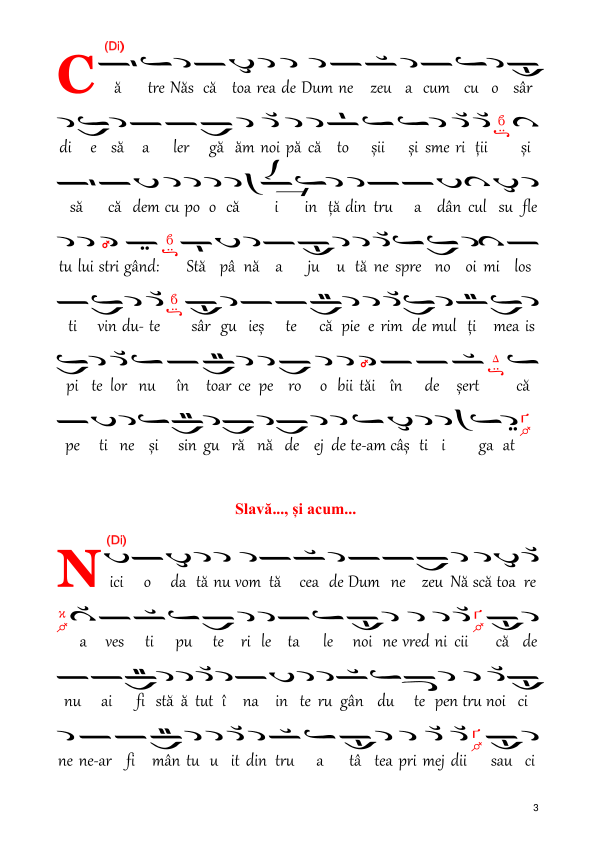

In [5]:
sheet[2].image

32


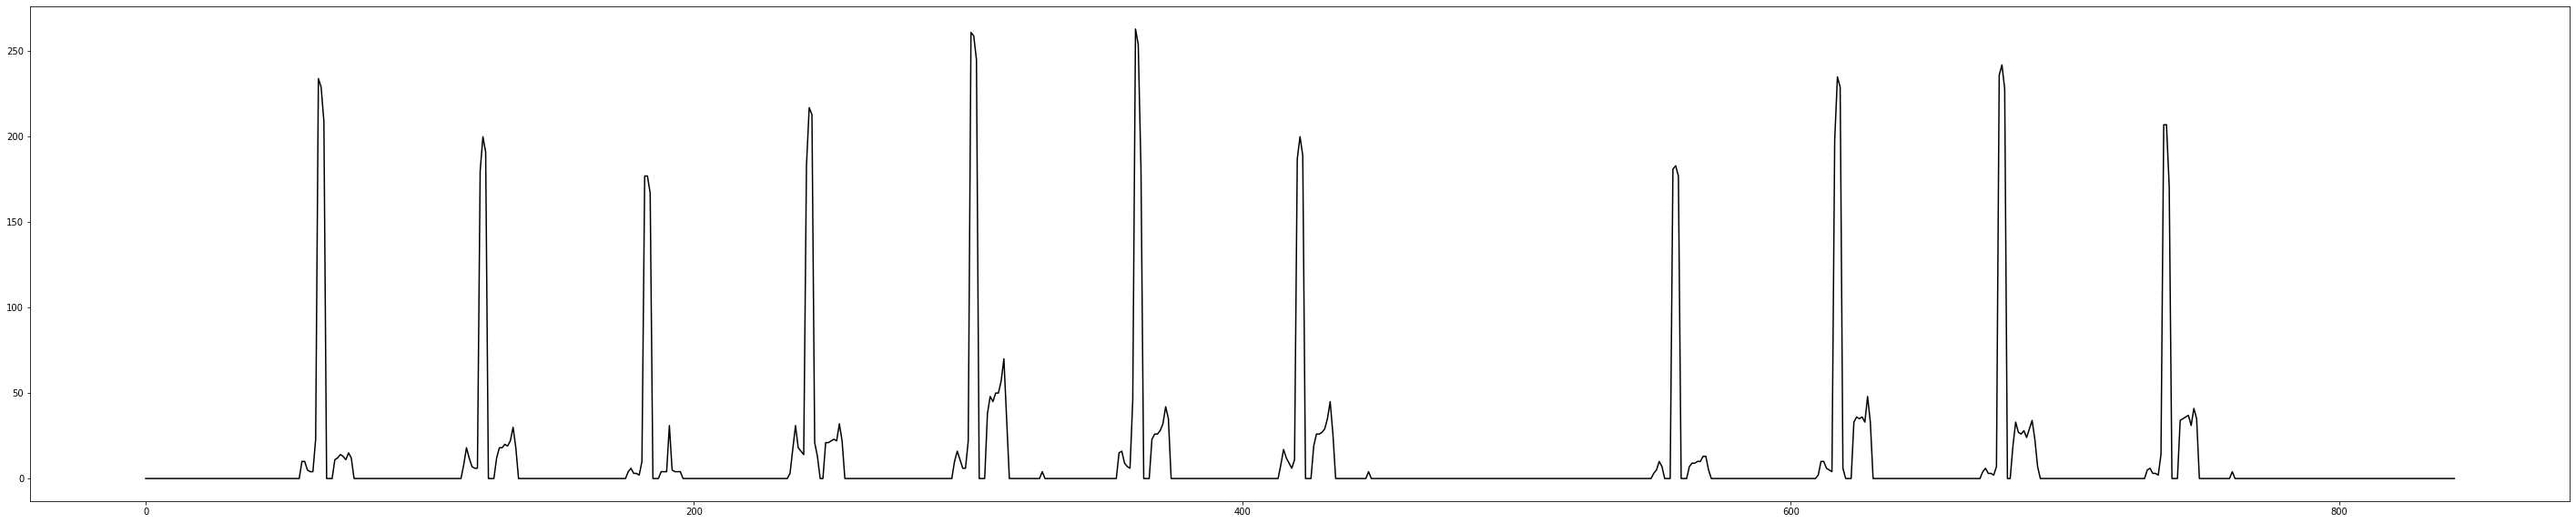

In [6]:
print(sheet.oligon_width)
sheet[2].plot_horizontal_projection()

In [10]:
(unique, counts) = np.unique(sheet[2].thresh, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[     0, 474461],
       [   255,  27371]])

In [11]:
def plot_page(page):
  import matplotlib.pyplot as plt
  import matplotlib.patches as patches

  # Create figure and axes
  fig, ax = plt.subplots(figsize=(page.height / 10, page.width / 10))

  # Display the image
  ax.imshow(page.image)

  # Create a Rectangle patch
  max_x, max_y = 0, 0
  for index, (x, y, w, h, a) in enumerate(page.ccs):
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)
    print(f'index={index}, w={w}, h={h}')
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label=f'{index}')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2.0
    cy = ry + rect.get_height() / 2.0
    ax.annotate(f'{index}', (cx, cy), color='green', weight='bold', fontsize=16, ha='center', va='center')

  print(max_x)
  print(max_y)
  plt.show()

index=0, w=596, h=842
index=1, w=3, h=12
index=2, w=8, h=9
index=3, w=1, h=2
index=4, w=4, h=12
index=5, w=1, h=6
index=6, w=35, h=39
index=7, w=32, h=9
index=8, w=11, h=4
index=9, w=31, h=9
index=10, w=17, h=10
index=11, w=25, h=14
index=12, w=17, h=10
index=13, w=17, h=10
index=14, w=17, h=10
index=15, w=17, h=10
index=16, w=17, h=10
index=17, w=7, h=6
index=18, w=32, h=3
index=19, w=32, h=3
index=20, w=32, h=4
index=21, w=32, h=3
index=22, w=31, h=3
index=23, w=32, h=3
index=24, w=7, h=6
index=25, w=31, h=7
index=26, w=3, h=14
index=27, w=8, h=12
index=28, w=1, h=5
index=29, w=9, h=12
index=30, w=4, h=4
index=31, w=4, h=3
index=32, w=3, h=11
index=33, w=12, h=11
index=34, w=6, h=11
index=35, w=3, h=11
index=36, w=5, h=8
index=37, w=2, h=3
index=38, w=2, h=3
index=39, w=7, h=8
index=40, w=10, h=8
index=41, w=7, h=8
index=42, w=2, h=3
index=43, w=2, h=3
index=44, w=6, h=8
index=45, w=5, h=8
index=46, w=6, h=8
index=47, w=2, h=2
index=48, w=6, h=7
index=49, w=5, h=7
index=50, w=1, h=2


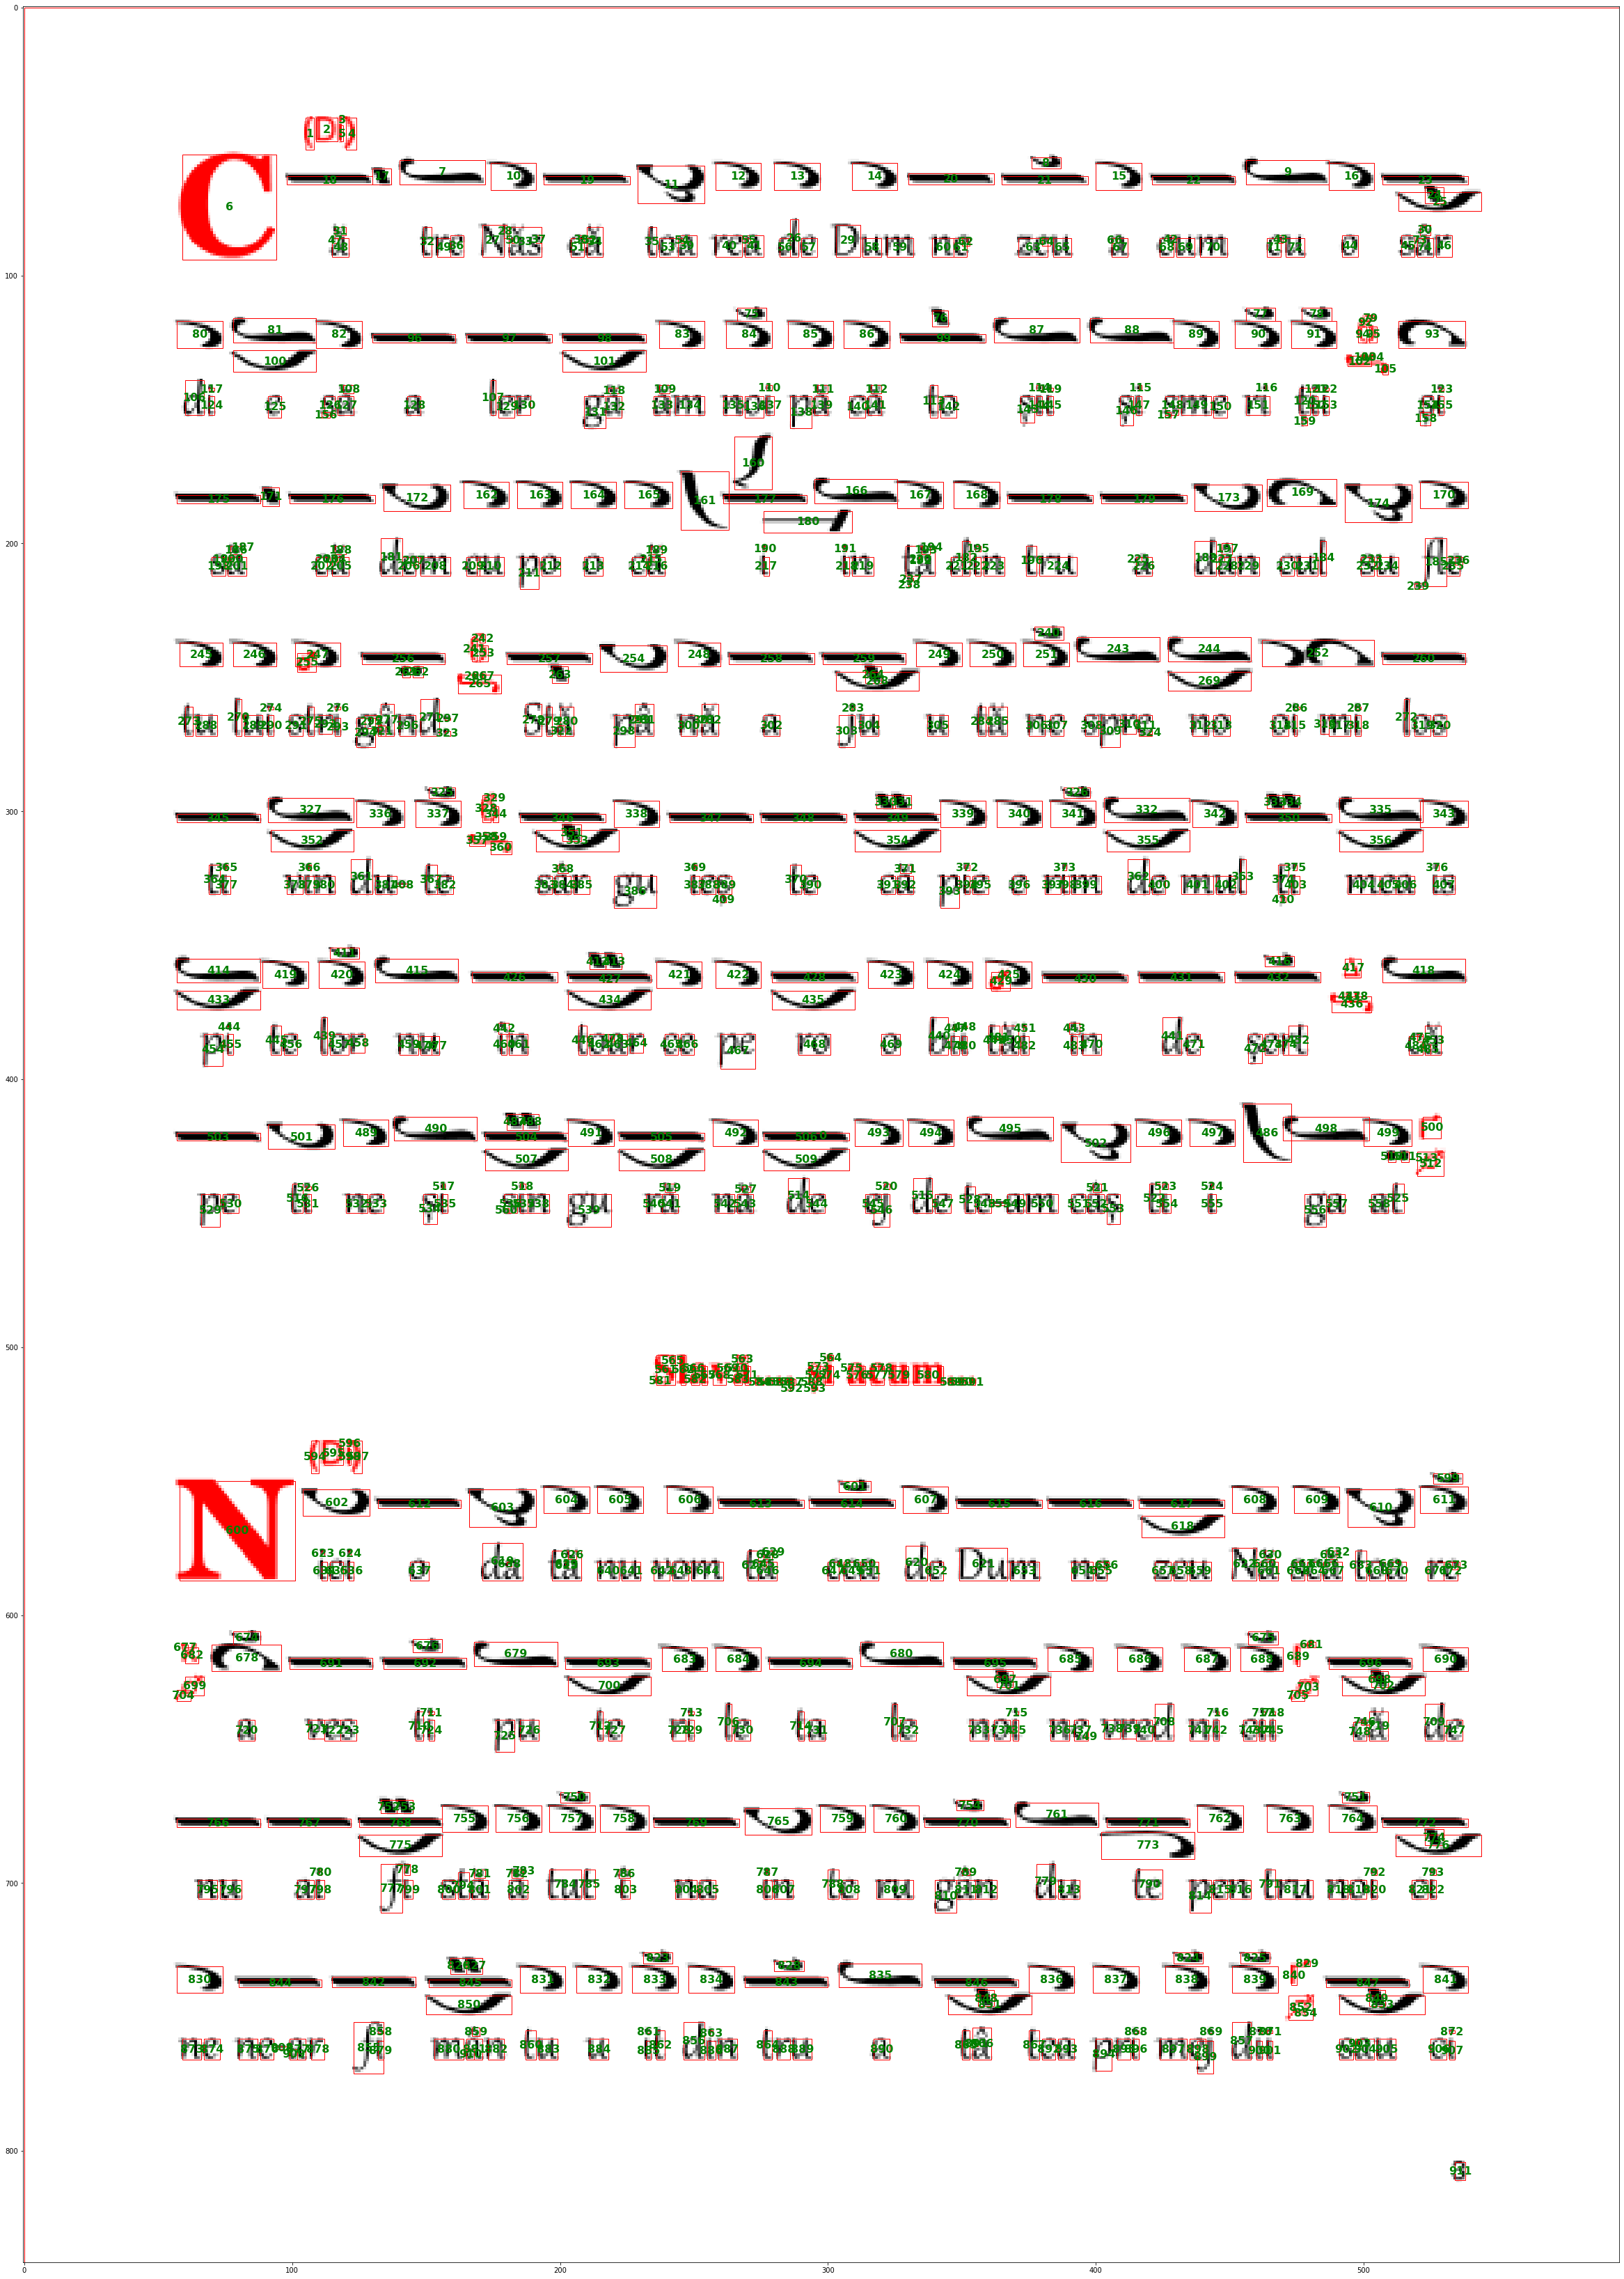

In [12]:
plot_page(sheet[2])